<a href="https://colab.research.google.com/github/prakash-bisht/NN_architecture_from-_scratch/blob/main/transformer_architecture_tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#positional_encoding&word_embedding

<a name='1'></a>
 Positional Encoding

In sequence to sequence tasks, the relative order of your data is extremely important to its meaning. When you were training sequential neural networks such as RNNs, you fed your inputs into the network in order. Information about the order of your data was automatically fed into your model.  However, when you train a Transformer network, you feed your data into the model all at once. While this dramatically reduces training time, there is no information about the order of your data. This is where positional encoding is useful - you can specifically encode the positions of your inputs and pass them into the network using these sine and cosine formulas:
    
$$
PE_{(pos, 2i)}= sin\left(\frac{pos}{{10000}^{\frac{2i}{d}}}\right)
\tag{1}$$
<br>
$$
PE_{(pos, 2i+1)}= cos\left(\frac{pos}{{10000}^{\frac{2i}{d}}}\right)
\tag{2}$$

* $d$ is the dimension of the word embedding and positional encoding
* $pos$ is the position of the word.
* $i$ refers to each of the different dimensions of the positional encoding.

The values of the sine and cosine equations are small enough (between -1 and 1) that when you add the positional encoding to a word embedding, the word embedding is not significantly distorted. The sum of the positional encoding and word embeding is ultimately what is fed into the model. Using a combination of these two equations helps your Transformer network attend to the relative positions of your input data. Note that while in the lectures Andrew uses vertical vectors but in this assignment, all vectors are horizontal. All matrix multiplications should be adjusted accordingly.

<a name='1-1'></a>


In [ ]:
"""Transformers use a smart positional encoding scheme, where each position/index is mapped to a vector.
 Hence, the output of the positional encoding layer is a matrix, where each row of the matrix represents an 
 encoded object of the sequence summed with its positional information.
 An example of the matrix that encodes only the positional information is shown in the figure below."""

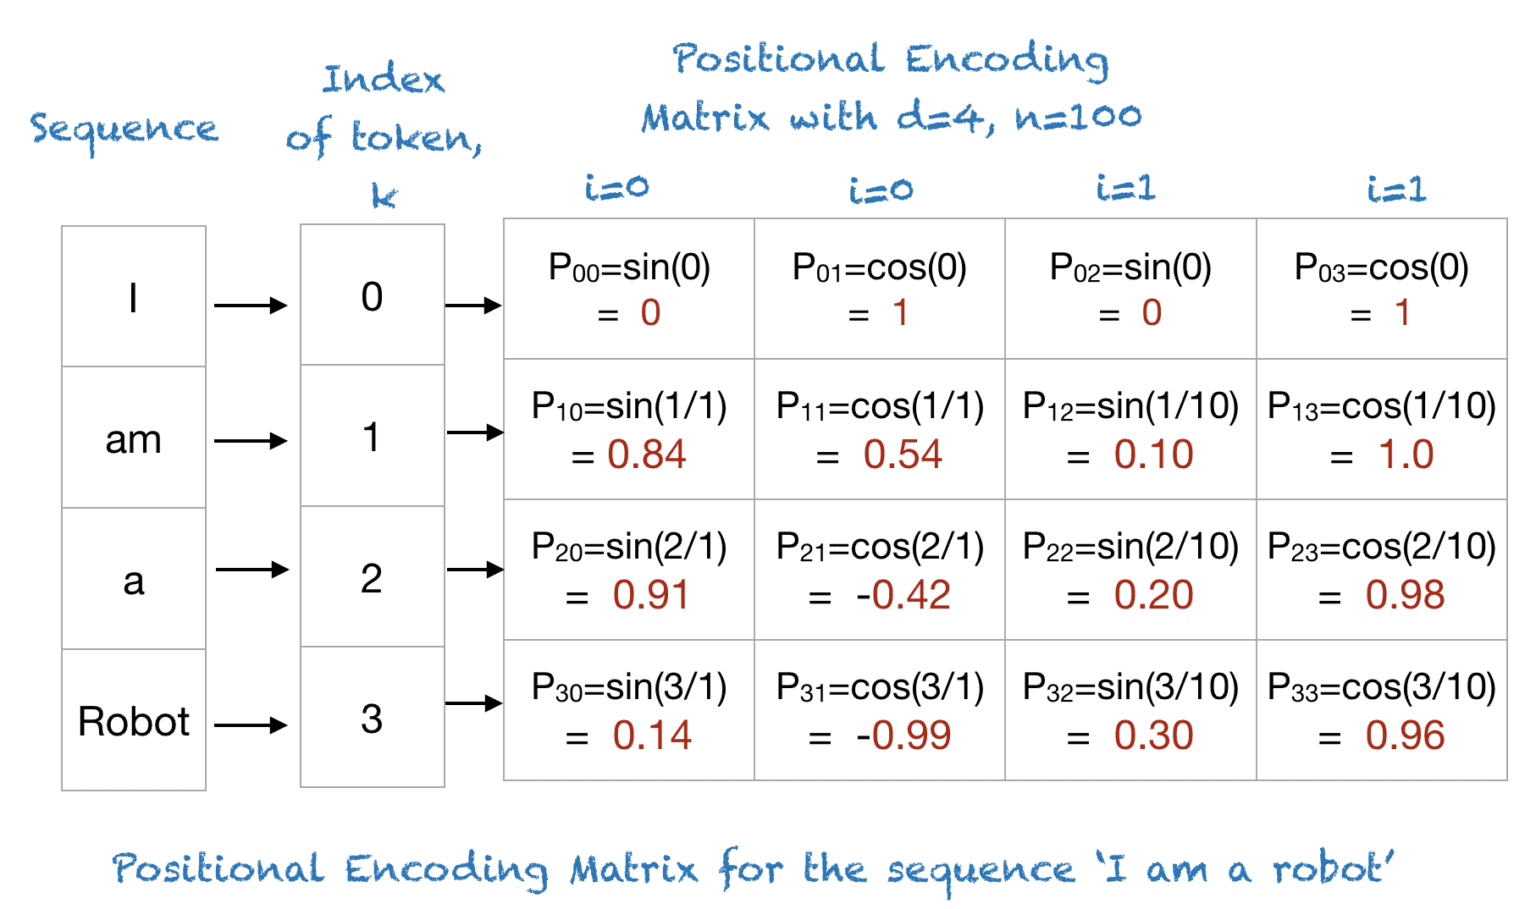

In [ ]:
from IPython.display import Image
Image(filename='positional_encode.png')

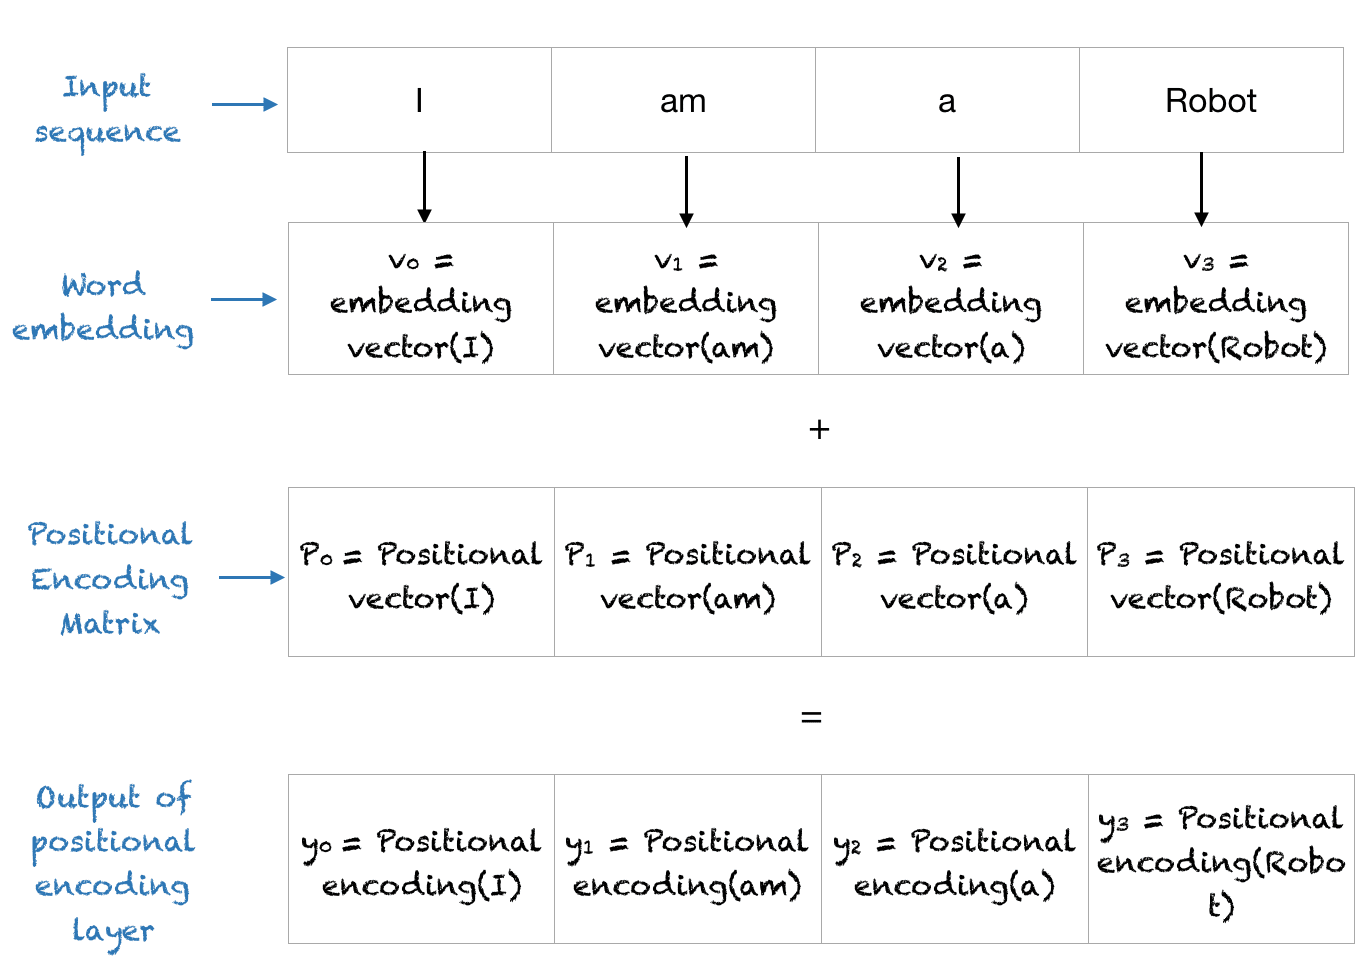

In [ ]:
Image(filename='output.png')

@The Text Vectorization Layer
The text vectorization layer creates a dictionary of words and replaces each word by its corresponding index in the dictionary.
I am a robot
you too robot
The output of the layer is a tensor of shape:
(number of sentences, output sequence length)

Vocabulary:  ['', '[UNK]', 'robot', 'you', 'too', 'i', 'am', 'a']
Vectorized words:  tf.Tensor(
[[5 6 7 2 0]
[3 4 2 0 0]], shape=(2, 5), dtype=int64)

@The Embedding Layer
The Keras Embedding layer converts integers to dense vectors. This layer maps these integers to random numbers, which are later tuned during the training phase. However, you also have the option to set the mapping to some predefined weight values (shown later). To initialize this layer, we need to specify the maximum value of an integer to map, along with the length of the output sequence.



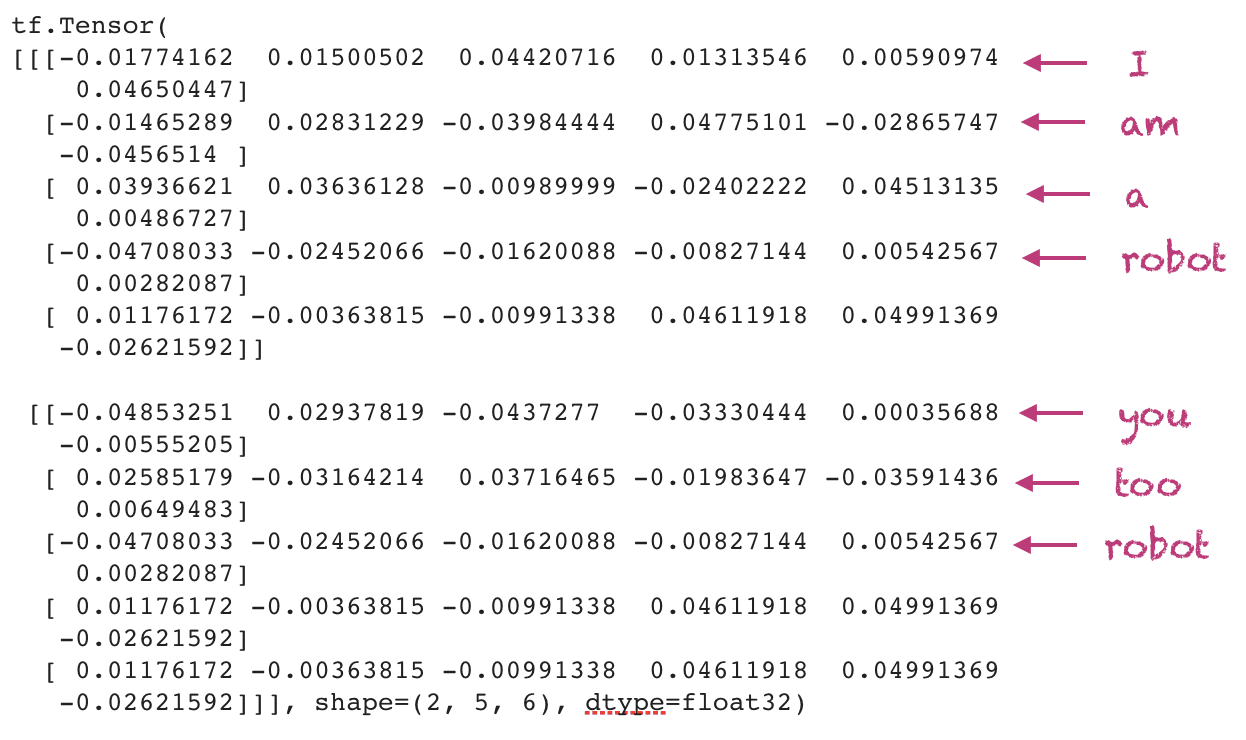

In [ ]:
#word embedding 
from IPython.display import Image
Image(filename='wordembed.png')

@position embedding

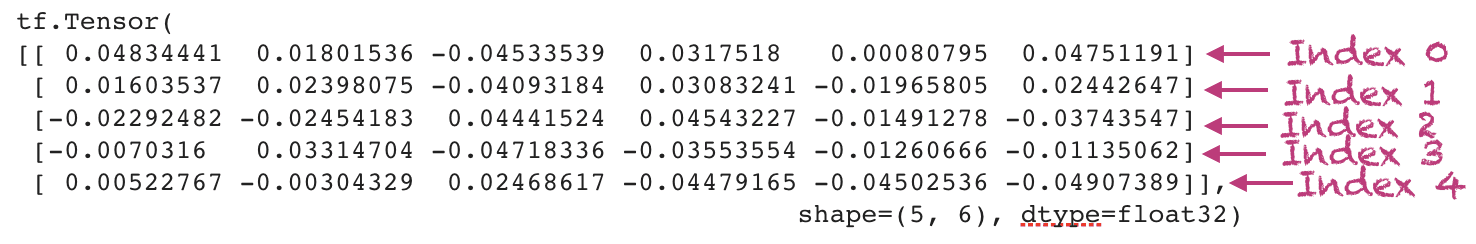

In [ ]:
#In a transformer model the final output is the sum of both the word embeddings and the position embeddings

In [ ]:
import tensorflow as tf
import pandas as pd
import time
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Embedding, MultiHeadAttention, Dense, Input, Dropout, LayerNormalization
from tqdm import tqdm_notebook as tqdm

In [ ]:
def get_angles(pos,i,d):
  angles = pos/(np.power(10000,(2 * (i//2)) / np.float32(d)))
  return angles

In [ ]:
def positional_encoding(positions,d):
  angle_rads = get_angles(np.arange(positions)[:,np.newaxis],np.arange(d)[np.newaxis,:],d)
  angle_rads[:,0::2] = np.sin(angle_rads[:,0::2])
  angle_rads[:,1::2] = np.cos(angle_rads[:,1::2])
  pos_encoding = angle_rads[np.newaxis, ...]
  return tf.cast(pos_encoding,tf.float32)

(1, 50, 512)


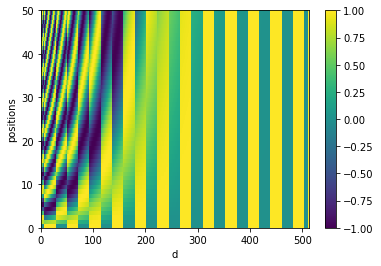

In [ ]:
pos_encoding = positional_encoding(50,512)
print(pos_encoding.shape)
plt.pcolormesh(pos_encoding[0])
plt.xlabel('d')
plt.ylabel('positions')
plt.colorbar()
plt.show()

#Masking

In [ ]:
#Each row represents a positional encoding - notice how none of the rows are identical! We have created a unique positional encoding for each of the words.

@Padding Mask

Oftentimes your input sequence will exceed the maximum length of a sequence your network can process. Let's say the maximum length of your model is five, it is fed the following sequences:

[["Do", "you", "know", "when", "Jane", "is", "going", "to", "visit", "Africa"],

 ["Jane", "visits", "Africa", "in", "September" ],

 ["Exciting", "!"]
]

which might get vectorized as:

[[ 71, 121, 4, 56, 99, 2344, 345, 1284, 15],

 [ 56, 1285, 15, 181, 545],

 [ 87, 600]
]

When passing sequences into a transformer model, it is important that they are of uniform length. You can achieve this by padding the sequence with zeros, and truncating sentences that exceed the maximum length of your model:

[[ 71, 121, 4, 56, 99],

 [ 2344, 345, 1284, 15, 0],

 [ 56, 1285, 15, 181, 545],

 [ 87, 600, 0, 0, 0],
]

Sequences longer than the maximum length of five will be truncated, and zeros will be added to the truncated sequence to achieve uniform length. Similarly, for sequences shorter than the maximum length, they zeros will also be added for padding. However, these zeros will affect the softmax calculation - this is when a padding mask comes in handy! By multiplying a padding mask by -1e9 and adding it to your sequence, you mask out the zeros by setting them to close to negative infinity

In [ ]:
"""After masking, your input should go from [87, 600, 0, 0, 0] to [87, 600, -1e9, -1e9, -1e9], 
so that when you take the softmax, the zeros don't affect the score."""

In [ ]:
def create_padding_mask(seq):
  seq = tf.cast(tf.math.equal(seq,0),tf.float32)
  return seq[:,tf.newaxis,tf.newaxis,:]

In [ ]:
x = tf.constant([[7., 6., 0., 0., 1.], [1., 2., 3., 0., 0.], [0., 0., 0., 4., 5.]])
print(create_padding_mask(x))

tf.Tensor(
[[[[0. 0. 1. 1. 0.]]]


 [[[0. 0. 0. 1. 1.]]]


 [[[1. 1. 1. 0. 0.]]]], shape=(3, 1, 1, 5), dtype=float32)


In [ ]:
#If we multiply this mask by -1e9 and add it to the sample input sequences, the zeros are essentially set to negative infinity

In [ ]:
print(tf.keras.activations.softmax(x))
print(tf.keras.activations.softmax(x + create_padding_mask(x) * -1.0e9))

tf.Tensor(
[[7.2876644e-01 2.6809821e-01 6.6454901e-04 6.6454901e-04 1.8064314e-03]
 [8.4437378e-02 2.2952460e-01 6.2391251e-01 3.1062774e-02 3.1062774e-02]
 [4.8541026e-03 4.8541026e-03 4.8541026e-03 2.6502505e-01 7.2041273e-01]], shape=(3, 5), dtype=float32)
tf.Tensor(
[[[[7.2973627e-01 2.6845497e-01 0.0000000e+00 0.0000000e+00
    1.8088354e-03]
   [2.4472848e-01 6.6524094e-01 0.0000000e+00 0.0000000e+00
    9.0030573e-02]
   [6.6483542e-03 6.6483542e-03 0.0000000e+00 0.0000000e+00
    9.8670328e-01]]]


 [[[7.3057163e-01 2.6876229e-01 6.6619512e-04 0.0000000e+00
    0.0000000e+00]
   [9.0030573e-02 2.4472848e-01 6.6524094e-01 0.0000000e+00
    0.0000000e+00]
   [3.3333334e-01 3.3333334e-01 3.3333334e-01 0.0000000e+00
    0.0000000e+00]]]


 [[[0.0000000e+00 0.0000000e+00 0.0000000e+00 2.6894143e-01
    7.3105860e-01]
   [0.0000000e+00 0.0000000e+00 0.0000000e+00 5.0000000e-01
    5.0000000e-01]
   [0.0000000e+00 0.0000000e+00 0.0000000e+00 2.6894143e-01
    7.3105860e-01]]]], shape

@Look-ahead Mask

The look-ahead mask follows similar intuition. In training, you will have access to the complete correct output of your training example. The look-ahead mask helps your model pretend that it correctly predicted a part of the output and see if, without looking ahead, it can correctly predict the next output.

For example, if the expected correct output is [1, 2, 3] and you wanted to see if given that the model correctly predicted the first value it could predict the second value, you would mask out the second and third values. So you would input the masked sequence [1, -1e9, -1e9] and see if it could generate [1, 2, -1e9].

In [ ]:
def create_look_ahead_mask(size):
  mask = tf.linalg.band_part(tf.ones((size,size)),-1,0)
  return mask

In [ ]:
x = tf.random.uniform((1, 3))
temp = create_look_ahead_mask(x.shape[1])
temp

<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[1., 0., 0.],
       [1., 1., 0.],
       [1., 1., 1.]], dtype=float32)>

#self_attention

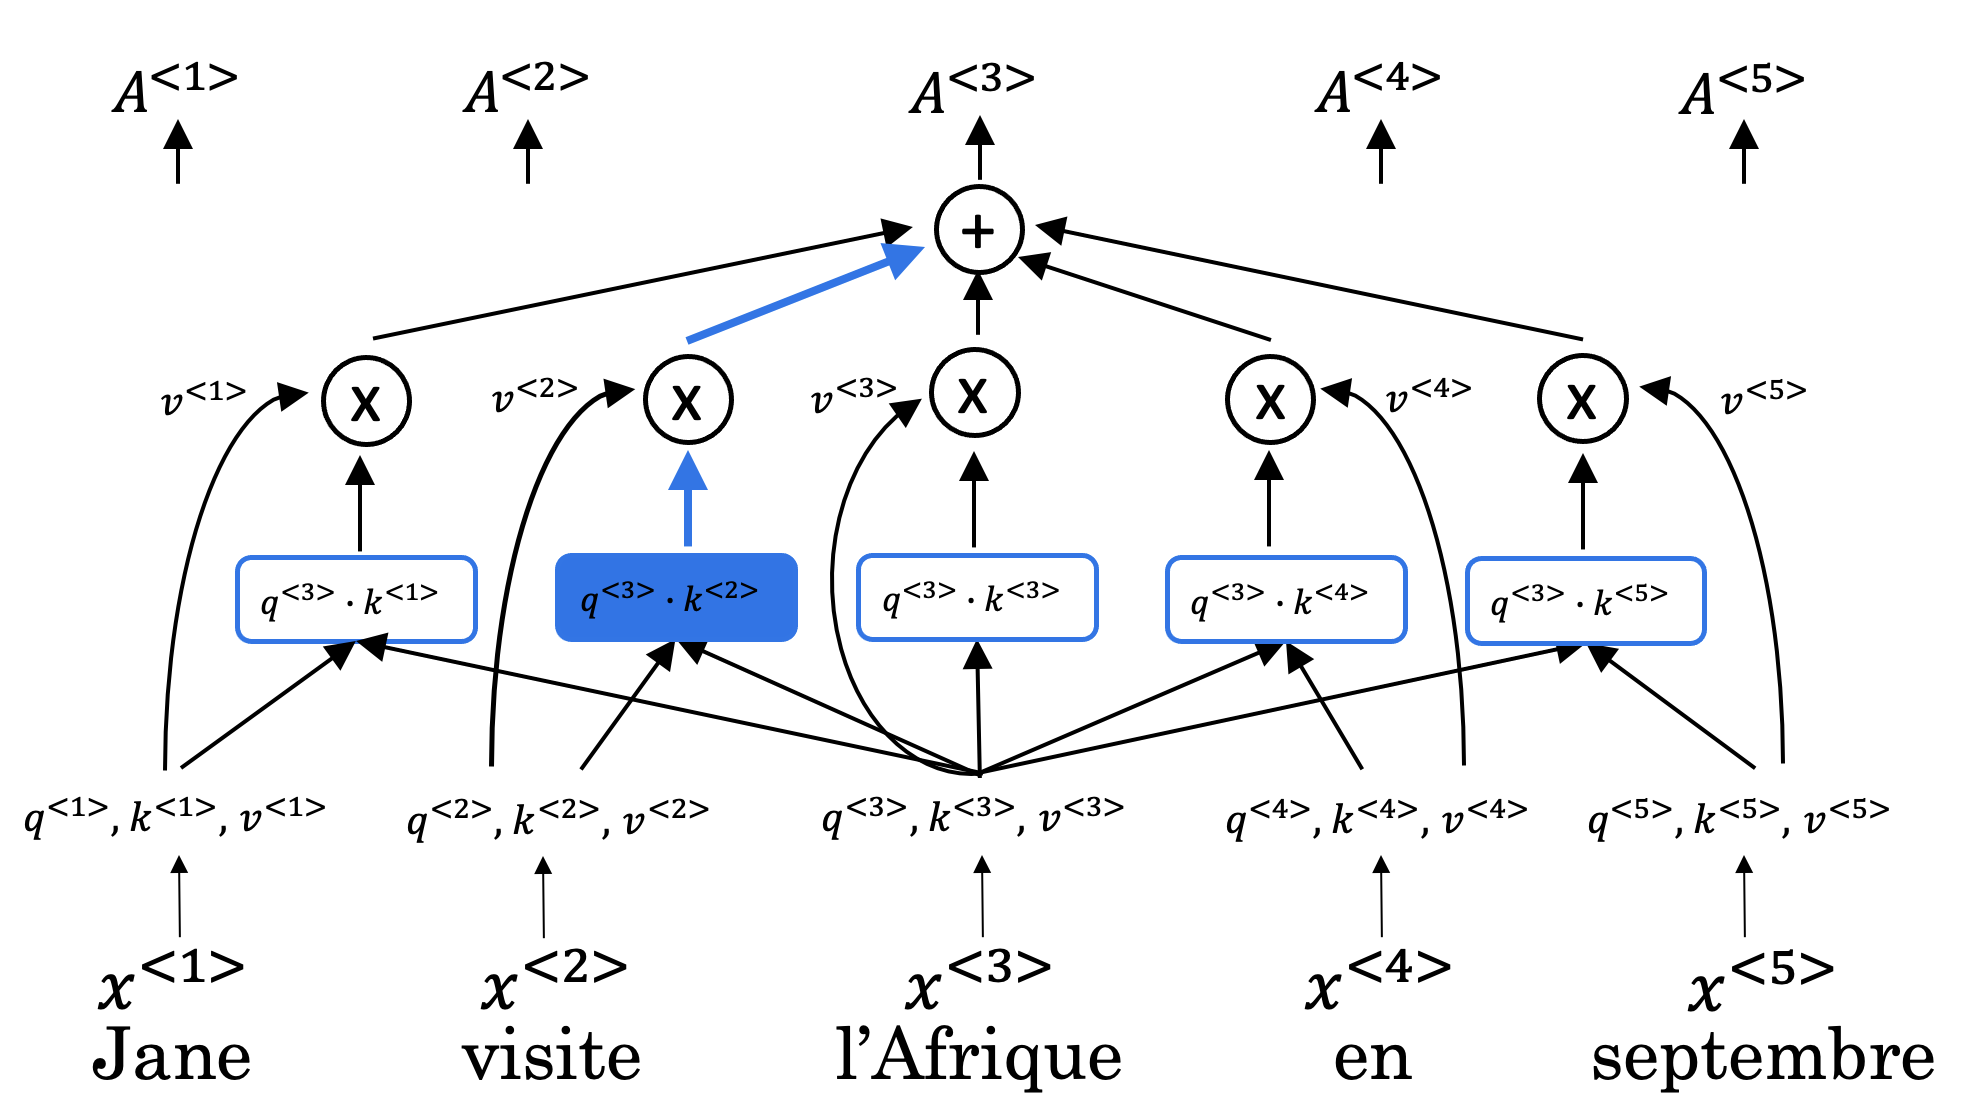

In [ ]:
from IPython.display import Image
Image(filename='self-attention.png')

In [ ]:
def scaled_dot_product_attention(q,k,v,mask):
  matmul_qk = tf.matmul(q,k,transpose_b=True)
  dk = tf.cast(tf.shape(k)[-1],tf.float32)
  scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)
  if mask is not None:
    scaled_attention_logits += (mask * -1.0e9)
  attention_weights = tf.nn.softmax(scaled_attention_logits,axis=-1)
  output = tf.matmul(attention_weights,v)
  return output,attention_weights 

#encoder

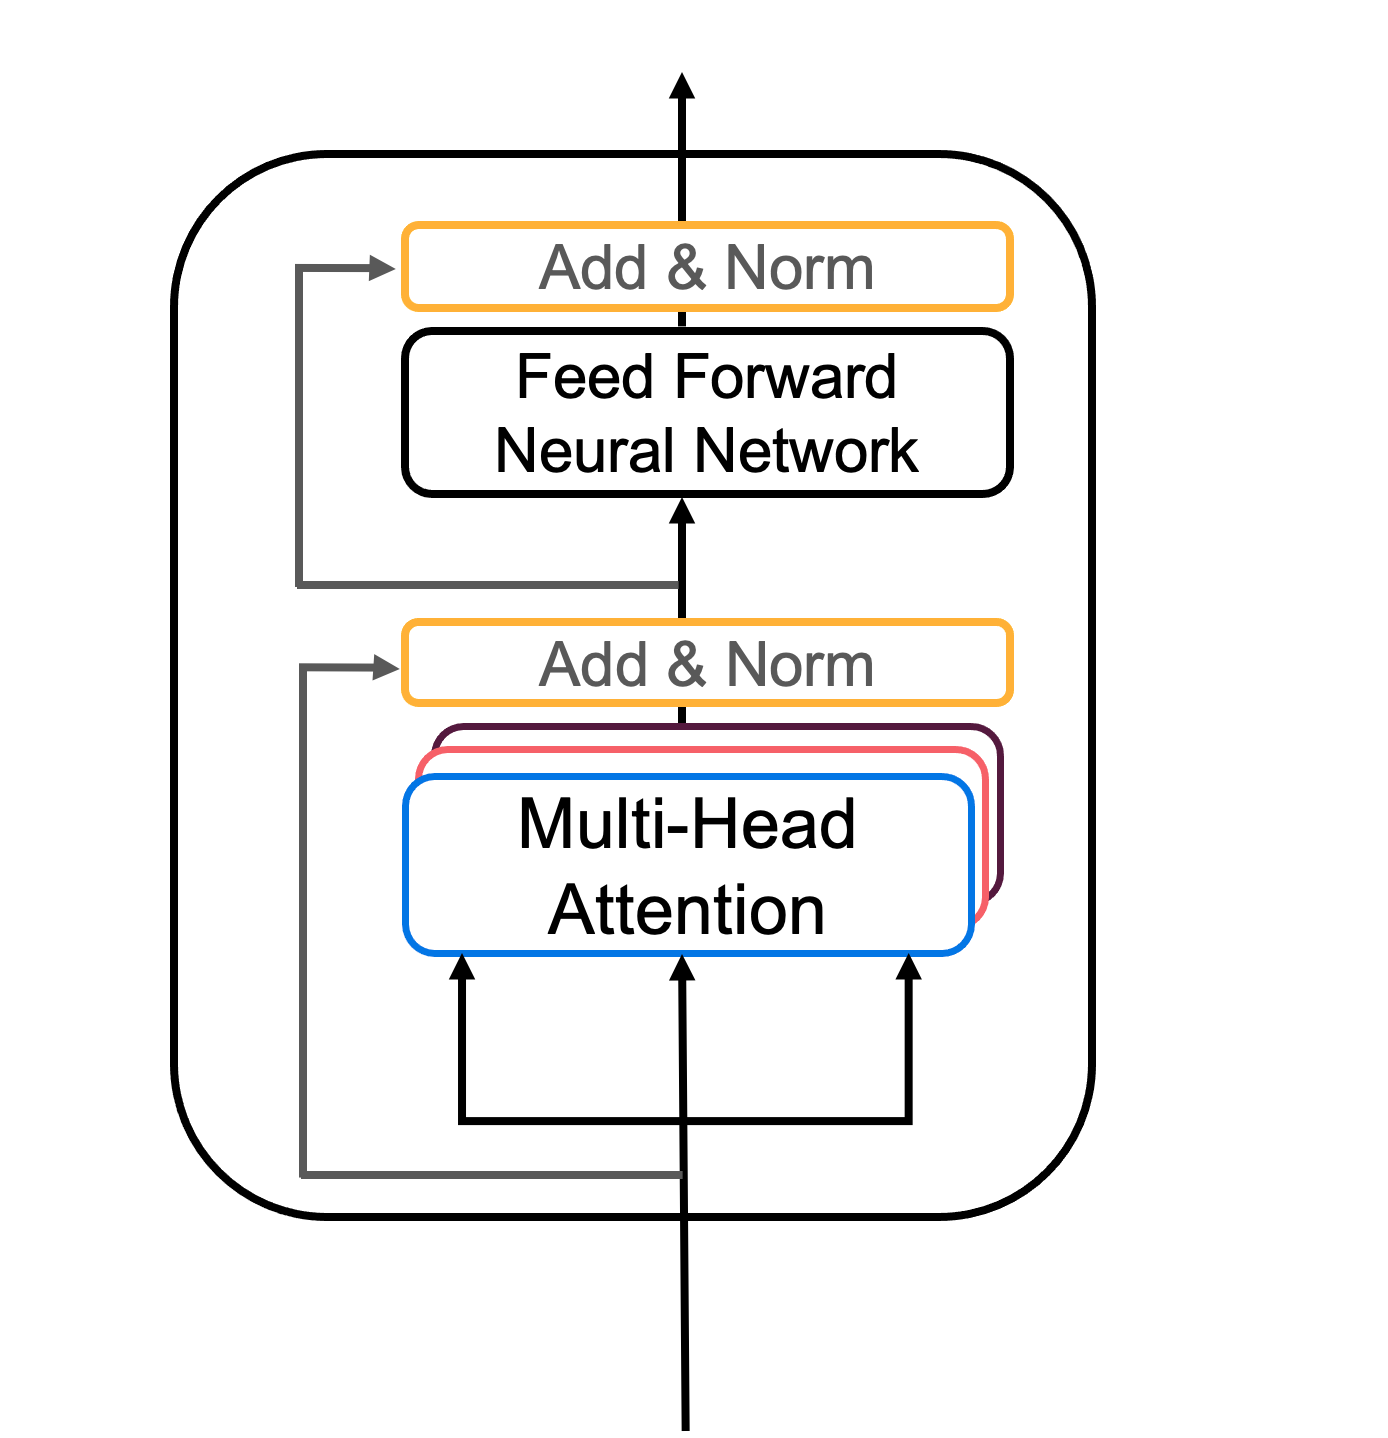

In [ ]:
Image(filename='encoder_layer.png')

In [ ]:
"""MultiHeadAttention you can think of as computing the self-attention several times to detect different features.
Feed forward neural network contains two Dense layers which we'll implement as the function FullyConnected"""

In [ ]:
def FullyConnected(embedding_dim,fully_connected_dim):
  return tf.keras.Sequential([
                              tf.keras.layers.Dense(fully_connected_dim,activation='relu'),
                              tf.keras.layers.Dense(embedding_dim)
  ])

@EncoderLayer

Implement EncoderLayer() using the call() method

we will pass the Q, V, K matrices and a boolean mask to a multi-head attention layer. Remember that to compute self-attention Q, V and K should be the same.

Next, you will pass the output of the multi-head attention layer to a dropout layer. Don't forget to use the training parameter to set the mode of your model.

Now add a skip connection by adding your original input x and the output of the dropout layer.

After adding the skip connection, pass the output through the first layer normalization.

Finally, repeat steps 1-4 but with the feed forward neural network instead of the multi-head attention layer.

In [ ]:
        """
        Forward pass for the Encoder Layer
        
        Arguments:
            x -- Tensor of shape (batch_size, input_seq_len, embedding_dim)
            training -- Boolean, set to true to activate
                        the training mode for dropout layers
            mask -- Boolean mask to ensure that the padding is not 
                    treated as part of the input
        Returns:
            out2 -- Tensor of shape (batch_size, input_seq_len, embedding_dim)
        """

In [ ]:
class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self,embedding_dim,num_heads,fully_connected_dim,dropout_rate=0.1,layernorm_eps=1e-6):
    super(EncoderLayer,self).__init__()
    self.mha = MultiHeadAttention(num_heads=num_heads,key_dim=embedding_dim)
    self.ffn = FullyConnected(embedding_dim=embedding_dim,fully_connected_dim=fully_connected_dim)
    self.layernorm1 = LayerNormalization(epsilon=layernorm_eps)
    self.layernorm2 = LayerNormalization(epsilon=layernorm_eps)
    self.dropout1 = Dropout(dropout_rate)
    self.dropout2 = Dropout(dropout_rate)
  def call(self,x,training,mask):
    self_attn_output = self.mha(x,x,x,mask)
    self_attn_output = self.dropout1(self_attn_output,training=training)
    mult_attn_out = self.layernorm1(x + self_attn_output)
    ffn_output = self.ffn(mult_attn_out)
    ffn_output = self.dropout2(ffn_output,training=training)
    encoder_layer_out = self.layernorm2(ffn_output + mult_attn_out)
    return encoder_layer_out

@Encoder 

Pass your input through the Embedding layer.

Scale your embedding by multiplying it by the square root of your embedding dimension. Remember to cast the embedding dimension to data type tf.float32 before computing the square root.

Add the position encoding: self.pos_encoding [:, :seq_len, :] to your embedding.

Pass the encoded embedding through a dropout layer, remembering to use the training parameter to set the model training mode.

Pass the output of the dropout layer through the stack of encoding layers using a for loop.

In [ ]:
     """
        Forward pass for the Encoder
        
        Arguments:
            x -- Tensor of shape (batch_size, input_seq_len)
            training -- Boolean, set to true to activate
                        the training mode for dropout layers
            mask -- Boolean mask to ensure that the padding is not 
                    treated as part of the input
        Returns:
            out2 -- Tensor of shape (batch_size, input_seq_len, embedding_dim)
        """


In [ ]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, num_layers, embedding_dim, num_heads, fully_connected_dim, input_vocab_size,
               maximum_position_encoding, dropout_rate=0.1, layernorm_eps=1e-6):
    super(Encoder,self).__init__()
    self.embedding_dim = embedding_dim 
    self.num_layers = num_layers 
    self.embedding = Embedding(input_vocab_size,self.embedding_dim)
    self.pos_encoding = positional_encoding(maximum_position_encoding,self.embedding_dim)
    self.enc_layers = [EncoderLayer(embedding_dim=self.embedding_dim,num_heads=num_heads,fully_connected_dim=fully_connected_dim
                                    ,dropout_rate=dropout_rate,layernorm_eps=layernorm_eps) for _ in range(self.num_layers)]
    self.dropout = Dropout(dropout_rate)
  def call(self,x,training,mask):
    seq_len =  tf.shape(x)[1]
    x = self.embedding(x)
    x *= tf.math.sqrt(tf.cast(self.embedding_dim,tf.float32))
    x += self.pos_encoding[:,:seq_len,:]
    x = self.dropout(x,training=training)
    for i in range(self.num_layers):
      x = self.enc_layers[i](x,training,mask)
    return x

#decoder

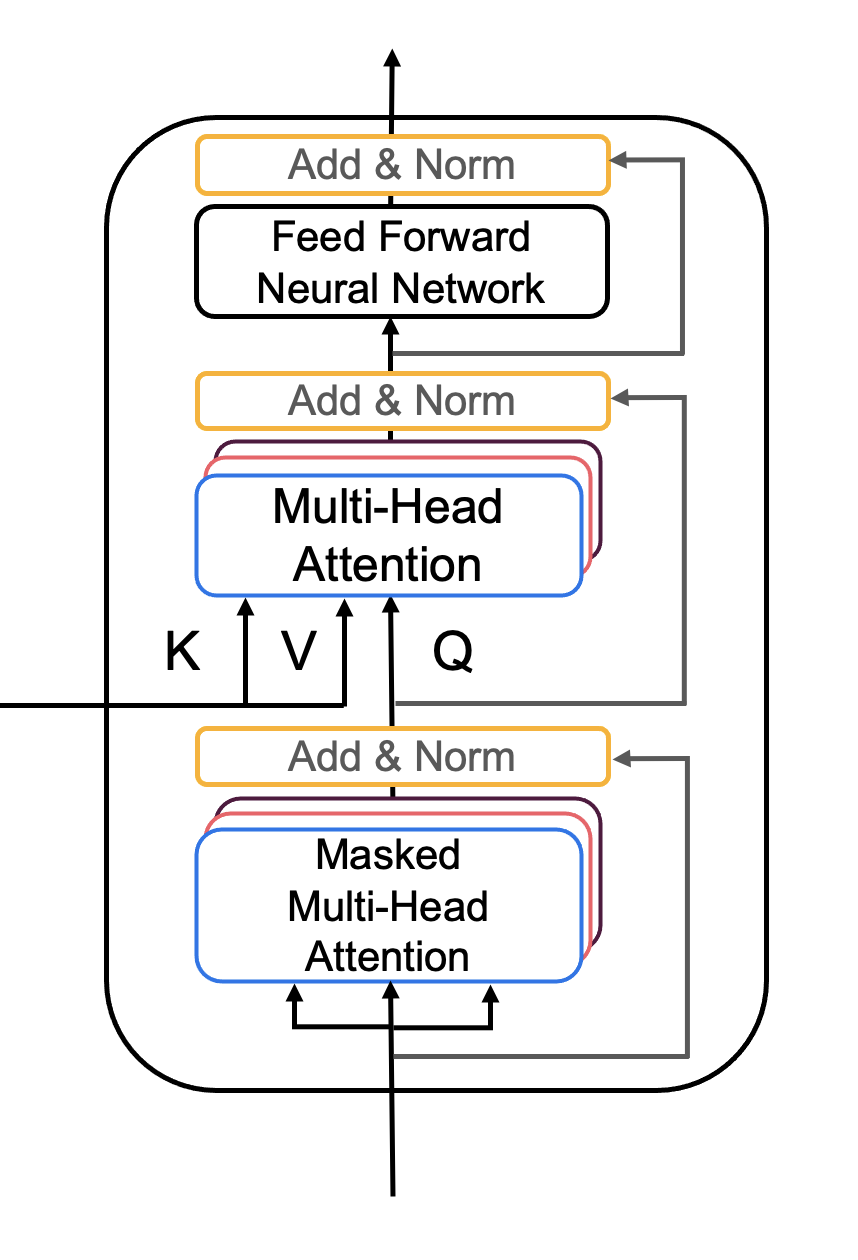

In [ ]:
        """
        Forward pass for the Decoder Layer
        
        Arguments:
            x -- Tensor of shape (batch_size, target_seq_len, embedding_dim)
            enc_output --  Tensor of shape(batch_size, input_seq_len, embedding_dim)
            training -- Boolean, set to true to activate
                        the training mode for dropout layers
            look_ahead_mask -- Boolean mask for the target_input
            padding_mask -- Boolean mask for the second multihead attention layer
        Returns:
            out3 -- Tensor of shape (batch_size, target_seq_len, embedding_dim)
            attn_weights_block1 -- Tensor of shape(batch_size, num_heads, target_seq_len, input_seq_len)
            attn_weights_block2 -- Tensor of shape(batch_size, num_heads, target_seq_len, input_seq_len)
        """

 **@DecoderLayer:**

Implement DecoderLayer() using the call() method

Block 1 is a multi-head attention layer with a residual connection, dropout layer, and look-ahead mask.

Block 2 will take into account the output of the Encoder, so the multi-head attention layer will receive K and V from the encoder, and Q from the Block 1. You will then apply a dropout layer, layer normalization and a residual connection, just like you've done before.

Finally, Block 3 is a feed forward neural network with dropout and normalization layers and a residual connection.

In [ ]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self,embedding_dim,num_heads,fully_connected_dim,dropout_rate=0.1,layernorm_eps=1e-6):
    super(DecoderLayer,self).__init__()
    self.mha1 = MultiHeadAttention(num_heads=num_heads,key_dim=embedding_dim)
    self.mha2 = MultiHeadAttention(num_heads=num_heads,key_dim=embedding_dim)
    self.ffn = FullyConnected(embedding_dim=embedding_dim,fully_connected_dim=fully_connected_dim)
    self.layernorm1 = LayerNormalization(epsilon=layernorm_eps)
    self.layernorm2 = LayerNormalization(epsilon=layernorm_eps)
    self.layernorm3 = LayerNormalization(epsilon=layernorm_eps)
    self.dropout1 = Dropout(dropout_rate)
    self.dropout2 = Dropout(dropout_rate)
    self.dropout3 = Dropout(dropout_rate)
  def call(self,x,enc_output,training,look_ahead_mask,padding_mask):
    attn1,attn_weights_block1 = self.mha1(x,x,x,look_ahead_mask,return_attention_scores=True)
    attn1 = self.dropout1(attn1,training=training)
    out1 = self.layernorm1(attn1 + x)
    attn2,attn_weights_block2 = self.mha2(out1,enc_output,enc_output,padding_mask,return_attention_scores=True)
    attn2 = self.dropout2(attn2,training=training)
    out2 = self.layernorm2(attn2 + out1)
    ffn_output = self.ffn(out2)
    ffn_output = self.dropout3(ffn_output,training=training)
    out3 = self.layernorm3(ffn_output + out2)
    return out3,attn_weights_block1,attn_weights_block2


**@Decoder**

Pass your generated output through the Embedding layer.

Scale your embedding by multiplying it by the square root of your embedding dimension. Remember to cast the embedding dimension to data type tf.float32 before computing the square root.

Add the position encoding: self.pos_encoding [:, :seq_len, :] to your embedding.

Pass the encoded embedding through a dropout layer, remembering to use the training parameter to set the model training mode.

Pass the output of the dropout layer through the stack of Decoding layers using a for loop.

In [ ]:
        """
        Forward  pass for the Decoder
        
        Arguments:
            x -- Tensor of shape (batch_size, target_seq_len, embedding_dim)
            enc_output --  Tensor of shape(batch_size, input_seq_len, embedding_dim)
            training -- Boolean, set to true to activate
                        the training mode for dropout layers
            look_ahead_mask -- Boolean mask for the target_input
            padding_mask -- Boolean mask for the second multihead attention layer
        Returns:
            x -- Tensor of shape (batch_size, target_seq_len, embedding_dim)
            attention_weights - Dictionary of tensors containing all the attention weights
                                each of shape Tensor of shape (batch_size, num_heads, target_seq_len, input_seq_len)
        """


In [ ]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, embedding_dim, num_heads, fully_connected_dim, target_vocab_size,
               maximum_position_encoding, dropout_rate=0.1, layernorm_eps=1e-6):
        super(Decoder, self).__init__()
        self.embedding_dim = embedding_dim
        self.num_layers = num_layers
        self.embedding = Embedding(target_vocab_size, self.embedding_dim)
        self.pos_encoding = positional_encoding(maximum_position_encoding, self.embedding_dim)
        self.dec_layers = [DecoderLayer(embedding_dim=self.embedding_dim,
                                        num_heads=num_heads,
                                        fully_connected_dim=fully_connected_dim,
                                        dropout_rate=dropout_rate,
                                        layernorm_eps=layernorm_eps) 
                           for _ in range(self.num_layers)]
        self.dropout = Dropout(dropout_rate)
    def call(self, x, enc_output, training,look_ahead_mask, padding_mask):
        seq_len = tf.shape(x)[1]
        attention_weights = {}
        x = self.embedding(x) 
        x *= tf.math.sqrt(tf.cast(self.embedding_dim, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]
        x = self.dropout(x, training=training)
        for i in range(self.num_layers):
            x, block1, block2 = self.dec_layers[i](x, enc_output, training, look_ahead_mask, padding_mask)
            attention_weights['decoder_layer{}_block1_self_att'.format(i+1)] = block1
            attention_weights['decoder_layer{}_block2_decenc_att'.format(i+1)] = block2
        return x, attention_weights

#Transformer

** `[bold text]ttps:// [link text](https://))`TRANSFORMER!!

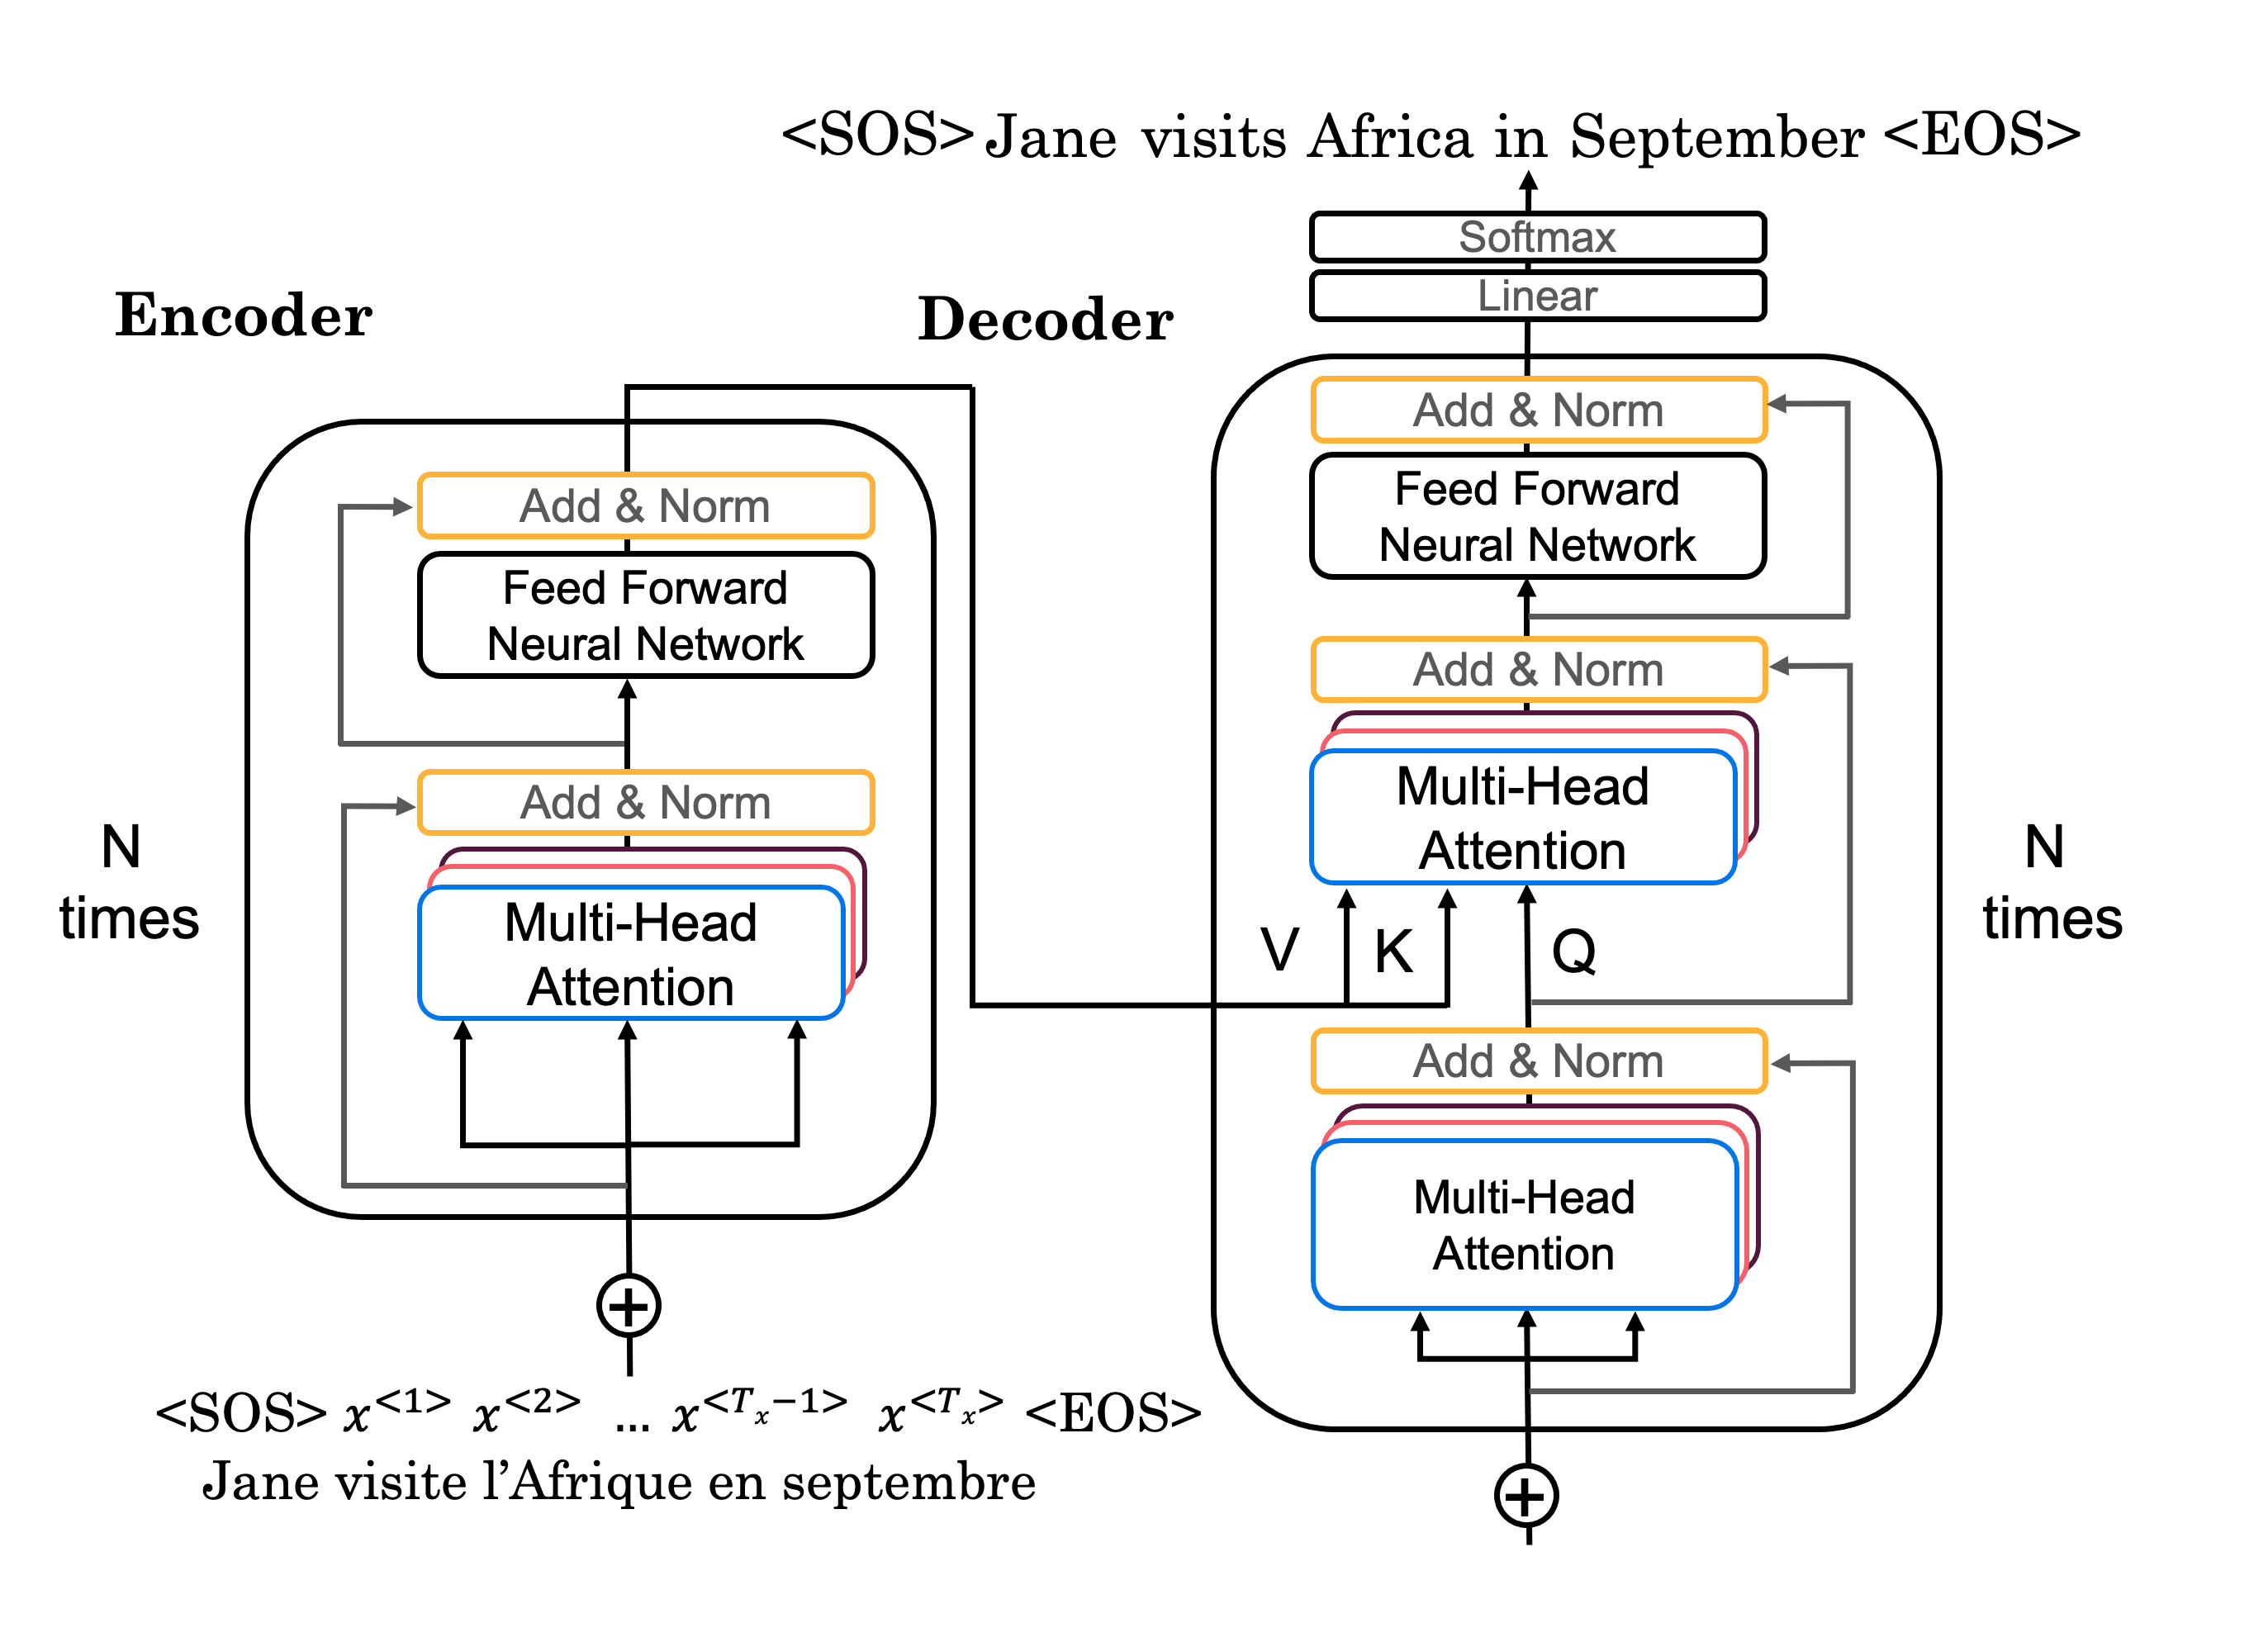

First your input passes through an Encoder, which is just repeated Encoder layers that you implemented:

embedding and positional encoding of your input

multi-head attention on your input

feed forward neural network to help detect features

Then the predicted output passes through a Decoder, consisting of the decoder layers that you implemented:

embedding and positional encoding of the output

multi-head attention on your generated output

multi-head attention with the Q from the first multi-head attention layer and the K and V from the Encoder

a feed forward neural network to help detect features

Finally, after the Nth Decoder layer, two dense layers and a softmax are applied to generate prediction for the next output in your sequence.

In [ ]:
        """
        Forward pass for the entire Transformer
        Arguments:
            inp -- Tensor of shape (batch_size, input_seq_len, fully_connected_dim)
            tar -- Tensor of shape (batch_size, target_seq_len, fully_connected_dim)
            training -- Boolean, set to true to activate
                        the training mode for dropout layers
            enc_padding_mask -- Boolean mask to ensure that the padding is not 
                    treated as part of the input
            look_ahead_mask -- Boolean mask for the target_input
            padding_mask -- Boolean mask for the second multihead attention layer
        Returns:
            final_output -- Describe me
            attention_weights - Dictionary of tensors containing all the attention weights for the decoder
                                each of shape Tensor of shape (batch_size, num_heads, target_seq_len, input_seq_len)
        
        """

In [ ]:
class Transformer(tf.keras.Model):
  def __init__(self, num_layers, embedding_dim, num_heads, fully_connected_dim, input_vocab_size, 
            target_vocab_size, max_positional_encoding_input,
            max_positional_encoding_target, dropout_rate=0.1, layernorm_eps=1e-6):
      super(Transformer, self).__init__()
      self.encoder = Encoder(num_layers=num_layers,
                            embedding_dim=embedding_dim,
                            num_heads=num_heads,
                            fully_connected_dim=fully_connected_dim,
                            input_vocab_size=input_vocab_size,
                            maximum_position_encoding=max_positional_encoding_input,
                            dropout_rate=dropout_rate,
                            layernorm_eps=layernorm_eps)
      self.decoder = Decoder(num_layers=num_layers, 
                            embedding_dim=embedding_dim,
                            num_heads=num_heads,
                            fully_connected_dim=fully_connected_dim,
                            target_vocab_size=target_vocab_size, 
                            maximum_position_encoding=max_positional_encoding_target,
                            dropout_rate=dropout_rate,
                            layernorm_eps=layernorm_eps)
      self.final_layer = Dense(target_vocab_size, activation='softmax')
  def call(self, inp, tar, training, enc_padding_mask, look_ahead_mask, dec_padding_mask):
      enc_output = self.encoder(inp,training,enc_padding_mask)
      dec_output, attention_weights = self.decoder(tar, enc_output, training, look_ahead_mask, dec_padding_mask)
      final_output = self.final_layer(dec_output)
      return final_output, attention_weights

In [ ]:
def Transformer_test(target): 
    tf.random.set_seed(10)
    num_layers = 6
    embedding_dim = 4
    num_heads = 4
    fully_connected_dim = 8
    input_vocab_size = 30
    target_vocab_size = 35
    max_positional_encoding_input = 5
    max_positional_encoding_target = 6
    trans = Transformer(num_layers, 
                        embedding_dim, 
                        num_heads, 
                        fully_connected_dim, 
                        input_vocab_size, 
                        target_vocab_size, 
                        max_positional_encoding_input,
                        max_positional_encoding_target)
    sentence_lang_a = np.array([[2, 1, 4, 3, 0]])
    sentence_lang_b = np.array([[3, 2, 1, 0, 0]])
    enc_padding_mask = np.array([[0, 0, 0, 0, 1]])
    dec_padding_mask = np.array([[0, 0, 0, 1, 1]])
    look_ahead_mask = create_look_ahead_mask(sentence_lang_a.shape[1])
    translation, weights = trans(
        sentence_lang_a,
        sentence_lang_b,
        True,
        enc_padding_mask,
        look_ahead_mask,
        dec_padding_mask
    )
    assert tf.is_tensor(translation), "Wrong type for translation. Output must be a tensor"
    shape1 = (sentence_lang_a.shape[0], max_positional_encoding_input, target_vocab_size)
    assert tuple(tf.shape(translation).numpy()) == shape1, f"Wrong shape. We expected {shape1}"       
    print(translation[0, 0, 0:8])
    assert np.allclose(translation[0, 0, 0:8],
                       [[0.02616475, 0.02074359, 0.01675757, 
                         0.025527, 0.04473696, 0.02171909, 
                         0.01542725, 0.03658631]]), "Wrong values in outd" 
    keys = list(weights.keys())
    assert type(weights) == dict, "Wrong type for weights. It must be a dict"
    assert len(keys) == 2 * num_layers, f"Wrong length for attention weights. It must be 2 x num_layers = {2*num_layers}"
    assert tf.is_tensor(weights[keys[0]]), f"Wrong type for att_weights[{keys[0]}]. Output must be a tensor"
    shape1 = (sentence_lang_a.shape[0], num_heads, sentence_lang_a.shape[1], sentence_lang_a.shape[1])
    assert tuple(tf.shape(weights[keys[1]]).numpy()) == shape1, f"Wrong shape. We expected {shape1}" 
    assert np.allclose(weights[keys[0]][0, 0, 1], [0.4992985, 0.5007015, 0., 0., 0.]), f"Wrong values in weights[{keys[0]}]"   
    print(translation)  
    print("\033[92mAll tests passed")  
Transformer_test(Transformer)

tf.Tensor(
[0.02616474 0.02074358 0.01675757 0.02552701 0.04473696 0.02171908
 0.01542725 0.0365863 ], shape=(8,), dtype=float32)
tf.Tensor(
[[[0.02616474 0.02074358 0.01675757 0.02552701 0.04473696 0.02171908
   0.01542725 0.0365863  0.02433536 0.0294879  0.01698964 0.02147778
   0.05749574 0.02669399 0.01277918 0.03276357 0.0253941  0.01698772
   0.02758245 0.02529753 0.04394253 0.06258808 0.03667333 0.03009712
   0.05011232 0.01414333 0.01601288 0.01800467 0.02506282 0.01607273
   0.06204056 0.02099288 0.03005534 0.03070701 0.01854689]
  [0.02490053 0.017258   0.01794803 0.02998915 0.05038004 0.01997478
   0.01526351 0.03385608 0.03138068 0.02608407 0.01852771 0.01744511
   0.05923332 0.03287777 0.01450072 0.02815487 0.02676623 0.01684978
   0.02482791 0.02307897 0.04122656 0.05552057 0.03742856 0.03390089
   0.04666695 0.01667501 0.01400229 0.01981527 0.02202851 0.01818
   0.0591845  0.02173372 0.03040997 0.03337187 0.02055808]
  [0.0186779  0.01225462 0.02509718 0.04180384 0.06244